<a href="https://colab.research.google.com/github/DanieleCecca/Food-Classification/blob/main/final_project_supervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Food Recognition

*Daniele Cecca*

*Matr. 914358*

*MSc Artificial Intelligence for Science and Technology*

*Email: d.cecca@campus.unimib.it*

This project focuses on the development and imple-
mentation of a **classification system for food identification**.
Automatic food identification can assist with food intake
monitoring to maintain a healthy diet. Food classification is a
challenging problem due to the large number of food categories,
high visual similarity between different food categories, as well
as the lack of datasets that are large enough for training deep
models.
The project explores two different approaches:

1. **SVM** classification wit **BAG-OF-WORDS** approach based on **SIFT** descriptors
2. **CNN** classification


## Utilities

In [ ]:
!pip install wandb
!pip install imblearn

I define some imports

In [ ]:
#Import to interact and manage files
import os
import shutil
import zipfile

#Import for data manipulation and analysis
import pandas as pd
import numpy as np
import cv2
import random

# Import for plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import for training BoW and SVM
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Metrics for evaluating the performance of machine learning models
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc

# Weights & Biases (wandb) for experiment tracking and model monitoring
import wandb

# PyTorch for building and training deep learning models
import torch
from torch import nn
import torch.nn.functional as F





To prepare the iFood2019 dataset, the following steps were executed:

- **Install Kaggle API**: The Kaggle API was installed to facilitate the dataset download.

- **Kaggle API Authentication**: The Kaggle API was authenticated using a kaggle.json file containing the necessary credentials.

- **Download the Dataset**: The iFood2019 dataset was downloaded from Kaggle in ZIP format.

- **Extract the Dataset**: The contents of the ZIP file were extracted to make the dataset accessible for further processing.





In [ ]:
#create the directory if not exist
!mkdir -p ~/.kaggle

#move kaggle.json from content to the created folder
shutil.move("/content/kaggle.json", "/root/.kaggle/kaggle.json")

#permissions
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
#Download the dataset
!kaggle competitions download -c ifood-2019-fgvc6

100% 2.84G/2.84G [00:31<00:00, 102MB/s] 
100% 2.84G/2.84G [00:31<00:00, 95.4MB/s]


In [ ]:
#Extract the Dataset
with zipfile.ZipFile("ifood-2019-fgvc6.zip") as zip_ref:
  zip_ref.extractall()

In [ ]:
!unzip -q train_set.zip -d train_set
!unzip -q test_set.zip -d test_set
!unzip -q val_set.zip -d val_set

We define some global paths to access to the folders/files in which there are the data

In [ ]:
test_csv=r'val_labels.csv'
train_csv=r'train_labels.csv'

folder_img_training='train_set/train_set'
folder_img_test='val_set/val_set'

folder_img_training_gray='img_training_gray'
folder_img_test_gray='img_test_gray'

class_list_path=r'class_list.txt'

folder_keypoints_training= 'keypoints_training'
folder_keypoint_test= 'keypoints_test'

folder_descriptors_training= 'descriptors_training'
folder_descriptors_test= 'descriptors_test'

## Utility functions Bow-SVM

I define some utilities fuction that will be used later in the first part

In [ ]:
def RGB_to_GRAY(data,folder_name):
    i=0
    for img_name in data['img_name']:
        img_path=os.path.join(folder_name,img_name)
        img=cv2.imread(img_path)
        img_gray  = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        cv2.imwrite(img_path,img_gray )# decide if create a new folder of new img images
        i+=1
        print(i)

In [ ]:
def histogram_equalization(data,folder_name):
    i=0
    clahe = cv2.createCLAHE()
    for img_name in data['img_name']:
        img_path=os.path.join(folder_name,img_name)
        img=cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
        img = clahe.apply(img)
        cv2.imwrite(img_path,img)
        i+=1
        print(i)

In [ ]:
def resize_images(data,folder_name, new_folder,height,width):
    if not os.path.exists(new_folder):
      os.makedirs(new_folder)

    i=0
    for img_name in data['img_name']:
        img_path=os.path.join(folder_name,img_name)
        img=cv2.imread(img_path)
        img = cv2.resize(img,(height,width),interpolation=cv2.INTER_LINEAR)
        new_img_path=os.path.join(new_folder,img_name)
        cv2.imwrite(new_img_path,img)
        i+=1
        print(i)


In [ ]:
def extract_features_sift(data,folder_name,folder_keypoint,folder_descriptors):
    if not os.path.exists(folder_keypoint):
      os.makedirs(folder_keypoint)
    if not os.path.exists(folder_descriptors):
      os.makedirs(folder_descriptors)
    i=0
    sift = cv2.SIFT_create()
    for img_name in data['img_name']:
        img_path=os.path.join(folder_name,img_name)
        img=cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
        kp, des = sift.detectAndCompute(img, None)
        i+=1
        print(i)

        # Extract coordinates (x, y) of keypoints
        kp_coordinates = np.array([keypoint.pt for keypoint in kp])

        keypoint_file = os.path.join(folder_keypoint, img_name.split('.')[0] + f'_{i}'+'_keypoints.npy')
        descriptor_file = os.path.join(folder_descriptors, img_name.split('.')[0] + f'_{i}'+'_descriptors.npy')

        np.save(keypoint_file, kp_coordinates)
        np.save(descriptor_file, des)

In [ ]:
def visualize_images(data,folder_name,rows=5,columns=4):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, columns*rows +1):
        img_name=data['img_name'].sample(1).iloc[0]
        img_path=os.path.join(folder_name,img_name)
        img=cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)
    plt.tight_layout()
    plt.show()

In [ ]:
def info_images(data,folder_name):
    info = {
        'img_name': [],
        'shape': []
    }
    for img_name in data['img_name']:
        img_path=os.path.join(folder_name,img_name)
        img=cv2.imread(img_path)

        info['img_name'].append(img_name)
        info['shape'].append(img.shape)

    return info

In [ ]:
def load_keypoints(folder_name):
    kp_list = []
    for file_path in os.listdir(folder_name):
        if file_path.endswith('.npy'):  # Assicurati che il file sia un file numpy
            kp_coordinates = np.load(os.path.join(folder_name, file_path), allow_pickle=True)
            kp = [cv2.KeyPoint(x, y,10.0) for x, y in kp_coordinates]  # Imposta la dimensione a 10.0
            kp_list.append(kp)
    return kp_list


In [ ]:
def load_descriptors_train(folder_name):
    d_list_batch1 = []
    d_list_batch2 = []
    count=0
    for file_path in os.listdir(folder_name):
        if file_path.endswith('.npy'):
            descriptors = np.load(os.path.join(folder_name, file_path), allow_pickle=True)
            count+=1
            if(count<len((os.listdir(folder_name)))):
                d_list_batch1.append(descriptors)
            else:
                d_list_batch2.append(descriptors)


    return d_list_batch1,d_list_batch2

In [ ]:
def load_descriptors(folder_name):
    d_list = []
    for file_path in os.listdir(folder_name):
        if file_path.endswith('.npy'):
            descriptors = np.load(os.path.join(folder_name, file_path), allow_pickle=True)
            d_list.append(descriptors)
    return d_list

In [ ]:
def visualize_keypoints(data,folder_name,keypoint_list,rows=5,columns=4):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, columns*rows +1):

        sample=data['img_name'].sample(1)
        img_name=sample.iloc[0]
        pos=sample.index[0]

        img_path=os.path.join(folder_name,img_name)
        img=cv2.imread(img_path)

        if len(img.shape) == 3 and img.shape[2] == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        img=cv2.drawKeypoints(img,keypoint_list[pos],img,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)
    plt.show()

In [ ]:
def visualize_histograms(histograms_list, rows=5, columns=4):
    fig=plt.figure(figsize=(8, 8))

    for i in range(1, columns*rows +1):
        pos=random.randint(0,len(histograms_list)-1)
        print(pos)
        fig.add_subplot(rows, columns, i)
        plt.bar(np.arange(len(histograms_list[pos])),histograms_list[pos], edgecolor='black')
        plt.tight_layout()
    plt.show()


In [ ]:
def create_small_dataset(df, n_samples):
    small_df = []
    for label in df.label.unique():
        label_df = df[df['label'] == label]
        if label_df.shape[0] < n_samples:
            sampled_df = label_df.sample(n_samples, replace=True)
        else:
            sampled_df = label_df.sample(n_samples, replace=False)
        small_df.append(sampled_df)

    return pd.concat(small_df, ignore_index=True)


In [ ]:
def extract_all_descriptors(d_list):
  all_small_descriptors=[]
  for features in d_list:
      for f in features:
        all_small_descriptors.append(f)
  return all_small_descriptors

In [ ]:
def reconstruct_d_list(d_list, dataset_reducted):
    reconstructed_d_list_img = []
    i = 0
    for img in d_list:
        reconstructed_d_list = []
        for _ in img:
            if i < len(dataset_reducted):
                reconstructed_d_list.append(dataset_reducted[i])
                i += 1
        reconstructed_d_list_img.append(reconstructed_d_list)
    return reconstructed_d_list_img

In [ ]:
def create_histograms_list(d_list):
  histograms_list=[]
  for features in d_list:
      clustering_predict=[]
      for f in features:
          clust=kmeans.predict((f.reshape(1, -1).astype(float)))
          clustering_predict.append(clust)
      histogram,_=np.histogram(clustering_predict,bins=k)
      histograms_list.append(histogram)
  return histograms_list

## Data preprocessing

### Loading data

The dataset is the dataset created for the iFood 2019 Challenge. The training data is composed of **118,475 training images** collected from the web while the test data is made of **11,994 images**. In total, the dataset contains **251 classes.**

Since the training **images are crawled from the web**, they often include images of **raw ingredients or processed and packaged food items**.Further, due to the fine-grained nature of food-categories, a training image may either be **incorrectly labeled** into a visually similar class or be annotated with with a **single label despite having multiple food item**.



In [ ]:
df_training=pd.read_csv(train_csv)
df_test=pd.read_csv(test_csv)

In [ ]:
print(f'Shape Training set:{df_training.shape}')
print(f'Shape Test set:{df_test.shape}')

Shape Training set:(118475, 2)
Shape Test set:(11994, 2)


Due to the **computational expense** of algorithms used to build the vocabulary of features, such as SIFT or K-means, I have decided to use only a **small portion of the data.** The primary limitation has been the amount of RAM available in the free version of Colab, which has provided only a few GBs.

I take **50 samples** for each class for **training** and **10 samples** **for test**. If some classes haven't had 50 samples for training or 10 samples for testing, I have decided to sample without replacement. This is the case for class 162.

In [ ]:
df_training=create_small_dataset(df_training, 50)
df_test=create_small_dataset(df_test, 10)

In [ ]:
print(f'Shape Training set:{df_training.shape}')
print(f'Shape Test set:{df_test.shape}')

Shape Training set:(12550, 2)
Shape Test set:(2510, 2)


In [ ]:
df_training.head(3)

img_name  label
0  train_101743.jpg    211
1  train_102099.jpg    211
2  train_101806.jpg    211

In [ ]:
df_test.head(3)

img_name  label
0  val_010404.jpg    247
1  val_011251.jpg    247
2  val_011659.jpg    247

In [ ]:
df_training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12550 entries, 0 to 12549
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   img_name  12550 non-null  object
 1   label     12550 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 196.2+ KB


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2510 entries, 0 to 2509
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   img_name  2510 non-null   object
 1   label     2510 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 39.3+ KB


In [ ]:
df_training['img_name'] = df_training['img_name'].astype('string')
df_test['img_name'] = df_test['img_name'].astype('string')

I visualize some samples of the training dataset

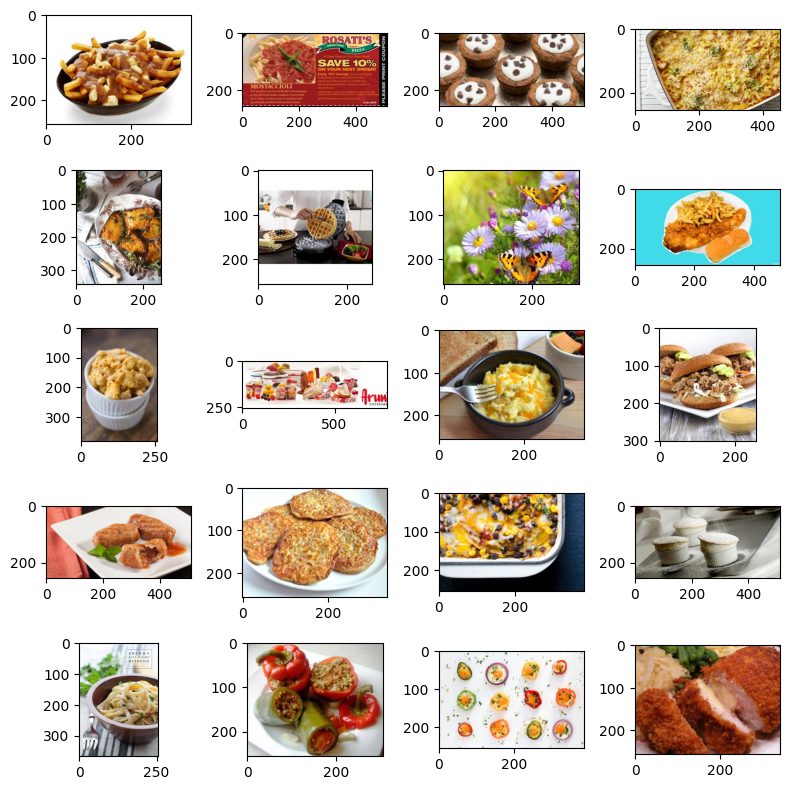

In [ ]:
visualize_images(df_training,folder_img_training)

In [ ]:
info=info_images(df_training,folder_img_training)
print((pd.DataFrame.from_dict(info)))

               img_name          shape
0      train_101823.jpg  (256, 348, 3)
1      train_101834.jpg  (256, 512, 3)
2      train_101745.jpg  (256, 341, 3)
3      train_102192.jpg  (256, 256, 3)
4      train_102053.jpg  (320, 256, 3)
...                 ...            ...
12545  train_101418.jpg  (384, 256, 3)
12546  train_101682.jpg  (384, 256, 3)
12547  train_101501.jpg  (256, 323, 3)
12548  train_101273.jpg  (256, 341, 3)
12549  train_101600.jpg  (256, 456, 3)

[12550 rows x 2 columns]


### Resize data

First of all, **I resize the images**. In this way, all the images will have the same size. I decide to resize them to **256 x 256** since this is the minimum value among all the images.

In [ ]:
resize_images(df_training,folder_img_training, folder_img_training_gray ,height=256,width=256)

Streaming output truncated to the last 5000 lines.
7551
7552
7553
7554
7555
7556
7557
7558
7559
7560
7561
7562
7563
7564
7565
7566
7567
7568
7569
7570
7571
7572
7573
7574
7575
7576
7577
7578
7579
7580
7581
7582
7583
7584
7585
7586
7587
7588
7589
7590
7591
7592
7593
7594
7595
7596
7597
7598
7599
7600
7601
7602
7603
7604
7605
7606
7607
7608
7609
7610
7611
7612
7613
7614
7615
7616
7617
7618
7619
7620
7621
7622
7623
7624
7625
7626
7627
7628
7629
7630
7631
7632
7633
7634
7635
7636
7637
7638
7639
7640
7641
7642
7643
7644
7645
7646
7647
7648
7649
7650
7651
7652
7653
7654
7655
7656
7657
7658
7659
7660
7661
7662
7663
7664
7665
7666
7667
7668
7669
7670
7671
7672
7673
7674
7675
7676
7677
7678
7679
7680
7681
7682
7683
7684
7685
7686
7687
7688
7689
7690
7691
7692
7693
7694
7695
7696
7697
7698
7699
7700
7701
7702
7703
7704
7705
7706
7707
7708
7709
7710
7711
7712
7713
7714
7715
7716
7717
7718
7719
7720
7721
7722
7723
7724
7725
7726
7727
7728
7729
7730
7731
7732
7733
7734
7735
7736
7737
7738
7739
7740

In [ ]:
resize_images(df_test,folder_img_test, folder_img_test_gray ,height=256,width=256)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


I visualize the resized images

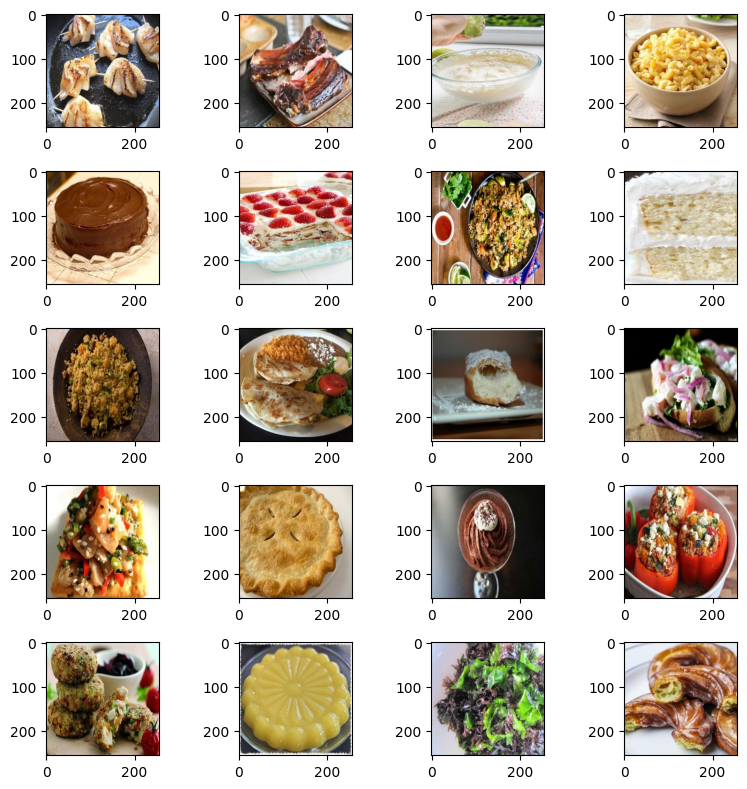

In [ ]:
visualize_images(df_test,folder_img_test_gray)

### Convert data

Then I convert the images **from RGB to grayscale** because SIFT only works with grayscale images.

In [ ]:
RGB_to_GRAY(df_training,folder_img_training_gray)

Streaming output truncated to the last 5000 lines.
7551
7552
7553
7554
7555
7556
7557
7558
7559
7560
7561
7562
7563
7564
7565
7566
7567
7568
7569
7570
7571
7572
7573
7574
7575
7576
7577
7578
7579
7580
7581
7582
7583
7584
7585
7586
7587
7588
7589
7590
7591
7592
7593
7594
7595
7596
7597
7598
7599
7600
7601
7602
7603
7604
7605
7606
7607
7608
7609
7610
7611
7612
7613
7614
7615
7616
7617
7618
7619
7620
7621
7622
7623
7624
7625
7626
7627
7628
7629
7630
7631
7632
7633
7634
7635
7636
7637
7638
7639
7640
7641
7642
7643
7644
7645
7646
7647
7648
7649
7650
7651
7652
7653
7654
7655
7656
7657
7658
7659
7660
7661
7662
7663
7664
7665
7666
7667
7668
7669
7670
7671
7672
7673
7674
7675
7676
7677
7678
7679
7680
7681
7682
7683
7684
7685
7686
7687
7688
7689
7690
7691
7692
7693
7694
7695
7696
7697
7698
7699
7700
7701
7702
7703
7704
7705
7706
7707
7708
7709
7710
7711
7712
7713
7714
7715
7716
7717
7718
7719
7720
7721
7722
7723
7724
7725
7726
7727
7728
7729
7730
7731
7732
7733
7734
7735
7736
7737
7738
7739
7740

In [ ]:
RGB_to_GRAY(df_test,folder_img_test_gray)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


I visualize the grayscale images

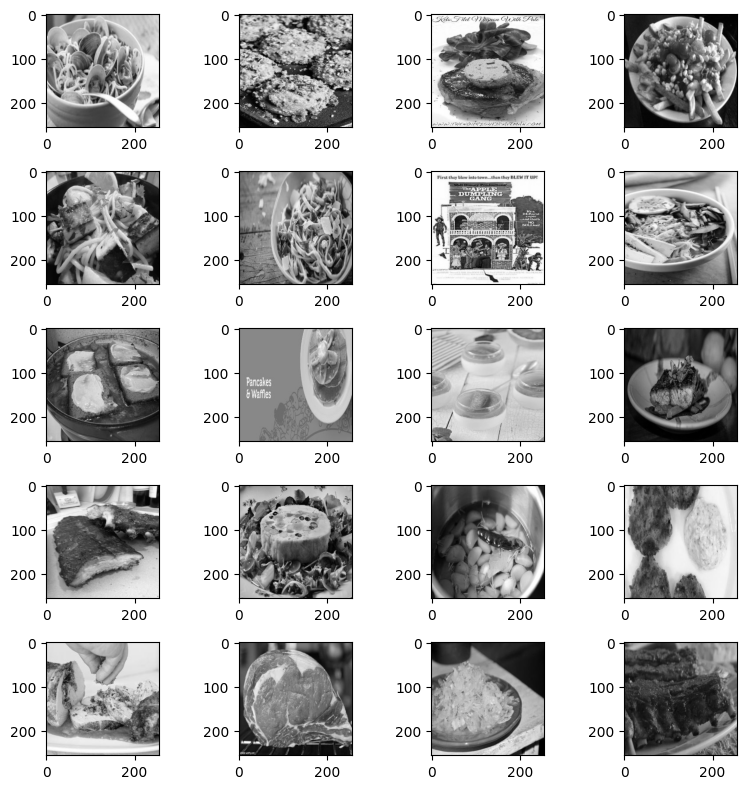

In [ ]:
visualize_images(df_training,folder_img_training_gray)

In [ ]:
info=info_images(df_training,folder_img_training)
print((pd.DataFrame.from_dict(info)))

               img_name          shape
0      train_101766.jpg  (256, 295, 3)
1      train_101836.jpg  (256, 341, 3)
2      train_102174.jpg  (256, 384, 3)
3      train_102073.jpg  (256, 328, 3)
4      train_102162.jpg  (256, 341, 3)
...                 ...            ...
12545  train_101327.jpg  (256, 341, 3)
12546  train_101372.jpg  (256, 452, 3)
12547  train_101627.jpg  (256, 455, 3)
12548  train_101615.jpg  (256, 487, 3)
12549  train_101500.jpg  (256, 384, 3)

[12550 rows x 2 columns]


### Normalizing the pixel values

Now I apply histogram equalization using **adaptive histogram equalization.**

In this method, the image is divided into small blocks called "tiles" (the defaulttile size is 8x8 in OpenCV).
Each of these blocks is histogram equalized individually. As a result, in a small area, the histogram will confine to a small region (unless there is noise).

If noise is present, it will be amplified.To avoid this, contrast limiting is applied. If any histogram bin is above the specified contrast limit (the default is 40 in OpenCV), those pixels are clipped and distributed uniformly to other bins before applying histogram equalization.

After equalization, bilinear interpolation is applied to remove artifacts at the tile borders. This method is suitable for improving the local contrast and enhancing the definitions of edges and corners in each region of an image. Thus, it should help the SIFT algorithm to find local features.

In [ ]:
histogram_equalization(df_training,folder_img_training_gray)

Streaming output truncated to the last 5000 lines.
7551
7552
7553
7554
7555
7556
7557
7558
7559
7560
7561
7562
7563
7564
7565
7566
7567
7568
7569
7570
7571
7572
7573
7574
7575
7576
7577
7578
7579
7580
7581
7582
7583
7584
7585
7586
7587
7588
7589
7590
7591
7592
7593
7594
7595
7596
7597
7598
7599
7600
7601
7602
7603
7604
7605
7606
7607
7608
7609
7610
7611
7612
7613
7614
7615
7616
7617
7618
7619
7620
7621
7622
7623
7624
7625
7626
7627
7628
7629
7630
7631
7632
7633
7634
7635
7636
7637
7638
7639
7640
7641
7642
7643
7644
7645
7646
7647
7648
7649
7650
7651
7652
7653
7654
7655
7656
7657
7658
7659
7660
7661
7662
7663
7664
7665
7666
7667
7668
7669
7670
7671
7672
7673
7674
7675
7676
7677
7678
7679
7680
7681
7682
7683
7684
7685
7686
7687
7688
7689
7690
7691
7692
7693
7694
7695
7696
7697
7698
7699
7700
7701
7702
7703
7704
7705
7706
7707
7708
7709
7710
7711
7712
7713
7714
7715
7716
7717
7718
7719
7720
7721
7722
7723
7724
7725
7726
7727
7728
7729
7730
7731
7732
7733
7734
7735
7736
7737
7738
7739
7740

In [ ]:
histogram_equalization(df_test,folder_img_test_gray)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


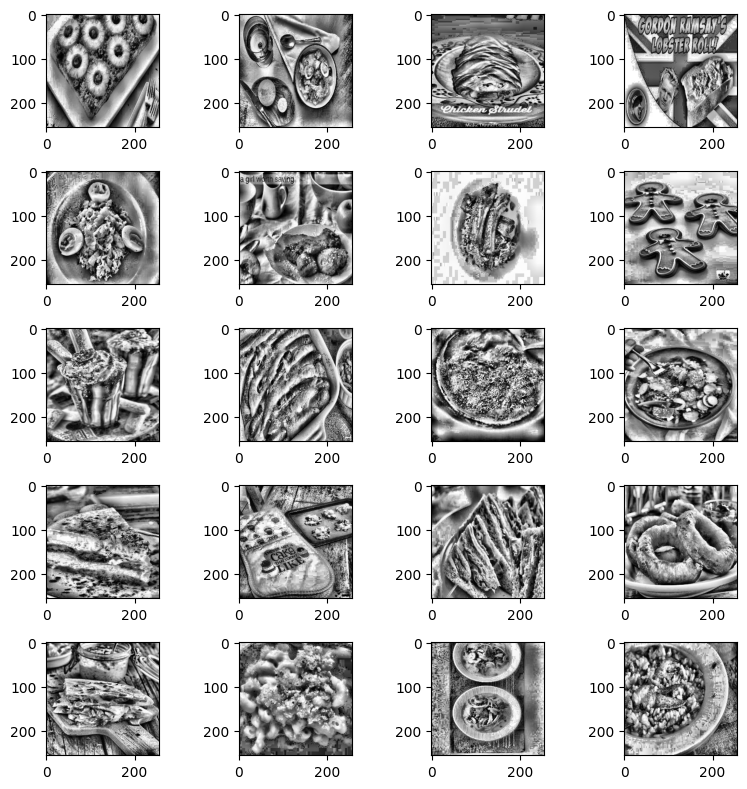

In [ ]:
visualize_images(df_test,folder_img_test_gray)

##  SVM classification wit BAG-OF-WORDS approach based on SIFT descriptors


The general step for this approach are the following ones:

1. **Extract keypoint** locations and descriptors using **SIFT**.

2. Apply dimensionality reduction using **PCA**.

3. **Cluster** the descriptors to form the **vocabulary** through quantization, where each cluster represents a word.

4. Compute the **BoW histogram** for each image by counting the occurrences of each word.

5. **Classify** the images using an **ML model**.

6. **Evaluate** the model



### Feature extraction-SIFT

To extract the features, I use the **Scale-Invariant Feature Transform (SIFT) algorithm.**

SIFT detects distinctive key points or features in an image that are robust to changes in scale, rotation, and affine transformations. It works by identifying key points based on their local intensity extrema and computing descriptors that capture the local image information around those key points.


I extract both the keypoints and descriptors for the training and for the test images.

In [ ]:
extract_features_sift(df_training,folder_img_training_gray,folder_keypoints_training,folder_descriptors_training)

Streaming output truncated to the last 5000 lines.
7551
7552
7553
7554
7555
7556
7557
7558
7559
7560
7561
7562
7563
7564
7565
7566
7567
7568
7569
7570
7571
7572
7573
7574
7575
7576
7577
7578
7579
7580
7581
7582
7583
7584
7585
7586
7587
7588
7589
7590
7591
7592
7593
7594
7595
7596
7597
7598
7599
7600
7601
7602
7603
7604
7605
7606
7607
7608
7609
7610
7611
7612
7613
7614
7615
7616
7617
7618
7619
7620
7621
7622
7623
7624
7625
7626
7627
7628
7629
7630
7631
7632
7633
7634
7635
7636
7637
7638
7639
7640
7641
7642
7643
7644
7645
7646
7647
7648
7649
7650
7651
7652
7653
7654
7655
7656
7657
7658
7659
7660
7661
7662
7663
7664
7665
7666
7667
7668
7669
7670
7671
7672
7673
7674
7675
7676
7677
7678
7679
7680
7681
7682
7683
7684
7685
7686
7687
7688
7689
7690
7691
7692
7693
7694
7695
7696
7697
7698
7699
7700
7701
7702
7703
7704
7705
7706
7707
7708
7709
7710
7711
7712
7713
7714
7715
7716
7717
7718
7719
7720
7721
7722
7723
7724
7725
7726
7727
7728
7729
7730
7731
7732
7733
7734
7735
7736
7737
7738
7739
7740

In [ ]:
extract_features_sift(df_test,folder_img_test_gray,folder_keypoint_test,folder_descriptors_test)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


I load the keypoints saved previuosly.

In [ ]:
kp_list_training=load_keypoints(folder_keypoints_training)

In [ ]:
kp_list_test=load_keypoints(folder_keypoint_test)

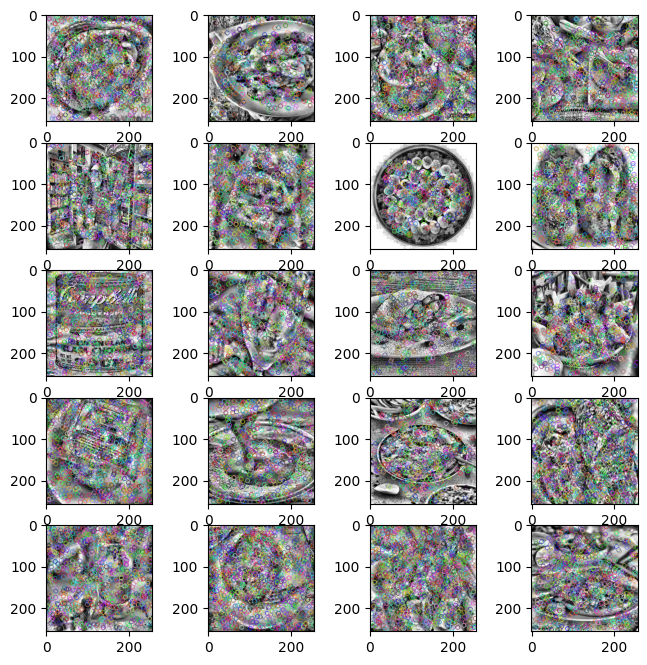

In [ ]:
visualize_keypoints(df_training,folder_img_training_gray,kp_list_training)

I load the descriptortors.

In [ ]:
d_list_training=load_descriptors(folder_descriptors_training)

In [ ]:
d_list_test=load_descriptors(folder_descriptors_test)

In [ ]:
print(f'Set of descriptors training :{len(d_list_training)}')
print(f'Set of descriptors test :{len(d_list_test)}')

Set of descriptors training :12550
Set of descriptors test :2510


In [ ]:
d_list_training[0].shape

(1001, 128)

### Dimensionality reduction PCA

First of all due to computational limits, I create a
smaller dataset with **10 images per class** and then I extract
the features using SIFT. After restructuring them, I save them into a single vector, resulting in a vector of lenght of **1268317**.

In [ ]:
small_d_list=[]
for label in df_test.label.unique():
    class_indices = df_test[df_test['label'] == label].index
    sample_indices = np.random.choice(class_indices, 5, replace=False)
    for idx in sample_indices:
        print(idx)
        small_d_list.append(d_list_test[idx])

7
2
8
9
4
10
17
12
15
19
29
25
28
21
24
35
31
37
30
38
41
48
47
44
45
50
58
53
59
55
64
66
62
69
67
72
73
70
75
74
85
89
84
80
81
90
91
99
98
93
102
101
109
108
103
119
114
115
116
118
125
128
123
122
127
132
136
137
130
139
142
144
146
141
148
150
154
159
151
155
167
169
165
164
163
176
179
171
172
175
184
187
186
188
189
196
199
197
191
195
208
200
202
204
209
219
217
218
212
213
228
222
221
229
220
230
234
237
238
232
244
240
247
246
243
259
254
255
250
256
264
267
265
261
263
275
271
270
278
273
284
289
281
286
288
297
294
291
299
290
302
301
300
307
309
319
314
311
313
312
327
323
324
322
329
331
336
335
337
333
349
341
348
343
346
355
352
358
351
356
363
369
362
364
361
371
375
376
373
372
384
386
387
385
389
390
395
396
391
394
406
404
400
405
402
416
413
418
412
414
421
427
425
420
426
432
439
433
436
435
445
443
441
440
449
458
457
453
455
459
468
460
469
467
462
476
479
474
470
472
485
484
483
489
486
494
492
497
491
493
502
508
509
501
504
519
514
516
511
512
526
529
527
522

In [ ]:
all_small_descriptors=extract_all_descriptors(small_d_list)

In [ ]:
print(f'Number of features :{len(all_small_descriptors)}')

Number of features :1268317


Even though it is not an essential step, I decided to apply **PCA** because the descriptors provide a much sparser set of points to work with. To determine the number of components,I used the **Kaiser rule**, which involves computing the numberof eigenvalues greater than one.

Furthermore I use **StandareScaler** before applying the PCA because PCA relies on the covariance matrix of the features. Standard scaling ensures that each feature contributes equally to the covariance matrix calculation. Without scaling, features with larger ranges might dominate the variance and covariance calculations.

In [ ]:
scaler = StandardScaler()
small_dataset_descriptor_standardized = scaler.fit_transform(all_small_descriptors)

In [ ]:
# Calculate the eigenvalues and eigenvectors
cov = pd.DataFrame(small_dataset_descriptor_standardized).cov()
eig_vals, eig_vecs = np.linalg.eig(cov)

# Calculate the sum of the eigenvalues
eig_vals_sum = eig_vals.sum()
print(f"Sum of eigenvalues: {eig_vals_sum:.2f}")

Sum of eigenvalues: 128.00


In [ ]:
kaiser_rule = np.where(eig_vals > 1)[0]
print(len(kaiser_rule))

30


In [ ]:
pca = PCA(n_components=30)

In [ ]:
small_dataset_reducted = pca.fit_transform(small_dataset_descriptor_standardized)

Now I do the same for the training and the test.

In [ ]:
all_training_descriptors=extract_all_descriptors(d_list_training)

In [ ]:
all_test_descriptors=extract_all_descriptors(d_list_test)

In [ ]:
train_dataset_standardize = scaler.fit_transform(all_training_descriptors)

In [ ]:
test_dataset_standardize = scaler.fit_transform(all_test_descriptors)

In [ ]:
train_dataset_reducted = pca.fit_transform(train_dataset_standardize)

In [ ]:
test_dataset_reducted = pca.fit_transform(test_dataset_standardize)

### Vocabulary Creation K-means

I apply **k-means to create the vocabulary**. I decide to use **k-means++** beacuse it doens't suffer of initialization problem.

To decide the number of k I use the **elbow method**, but due to computational limits I apply the k-means on a small fraction of the data (created previuosly)and then I apply it on all the data, with the chosen k.

In [ ]:
inertia_values=[]
i=0
for k in range(251, 1200, 100):
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=1 ,max_iter=300, tol=0.0001, verbose=0, random_state=30).fit(small_dataset_reducted)
    inertia_values.append(kmeans.inertia_)
    i=i+1
    print(i)

1
2
3
4
5
6
7
8
9
10


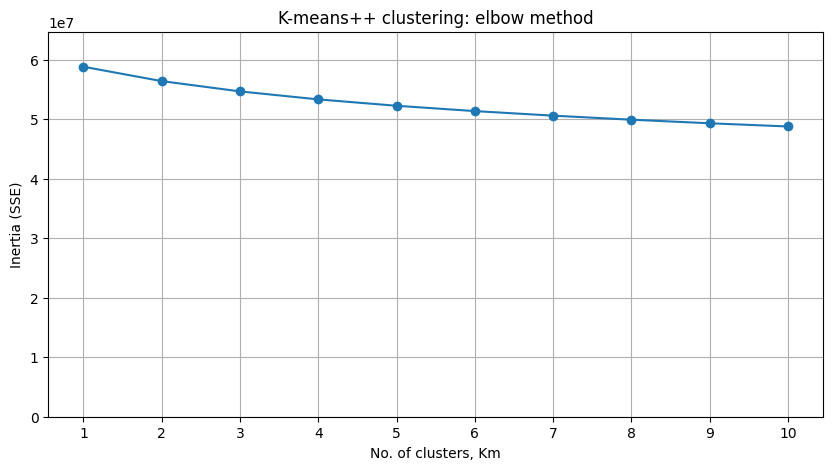

In [ ]:
# Elbow method.
plt.figure('K-means++ clustering: the elbow method', figsize=(10,5))
plt.plot(range(1,11), inertia_values, marker="o", linestyle="-")
plt.xticks(np.arange(1, 11, step=1))
plt.xlabel('No. of clusters, Km')
plt.ylabel('Inertia (SSE)')
plt.ylim([0, 1.1*np.max(inertia_values)])
plt.title("K-means++ clustering: elbow method")
plt.grid()
plt.show()

In [ ]:
np.save('content\test_dataset_reducted.npy', test_dataset_reducted)

# Save the train dataset
np.save('content\train_dataset_reducted.npy', train_dataset_reducted)

In [ ]:
k = 750
print(k)
kmeans = KMeans(n_clusters=k,n_init=1,init='k-means++').fit(small_dataset_reducted)

750


### Creation of histograms

After computing the vocabulary, I generate **histograms
of features** for each image, both for the images in the training
set and the test set.

Because for applying PCA I restructured the descriptors vector, now I have to reconstruct the d_list with the new descriptors, in such a way that each image(sample) have the original number of features.

In [ ]:
d_list_training_=reconstruct_d_list(d_list_training,train_dataset_reducted)
d_list_test_=reconstruct_d_list(d_list_test,test_dataset_reducted)

In [ ]:
print(f'Set of descriptors training :{len(d_list_training)}')
print(f'Set of descriptors test :{len(d_list_test)}')

Set of descriptors training :12550
Set of descriptors test :2510


In [ ]:
histograms_list_training=create_histograms_list(d_list_training_)

In [ ]:
histograms_list_test=create_histograms_list(d_list_test_)

I normalize the histrogram in such a way the value are within the interval \[0,1]

In [ ]:
histograms_list_training_norm=[histogram/np.sum(histogram) for histogram in histograms_list_training]

In [ ]:
histograms_list_test_norm=[histogram/np.sum(histogram) for histogram in histograms_list_test]

4423
6419
8070
2170
1394
9670
6096
783
12073
6067
7382
6892
9931
477
1070
721
7567
1680
11958
2256


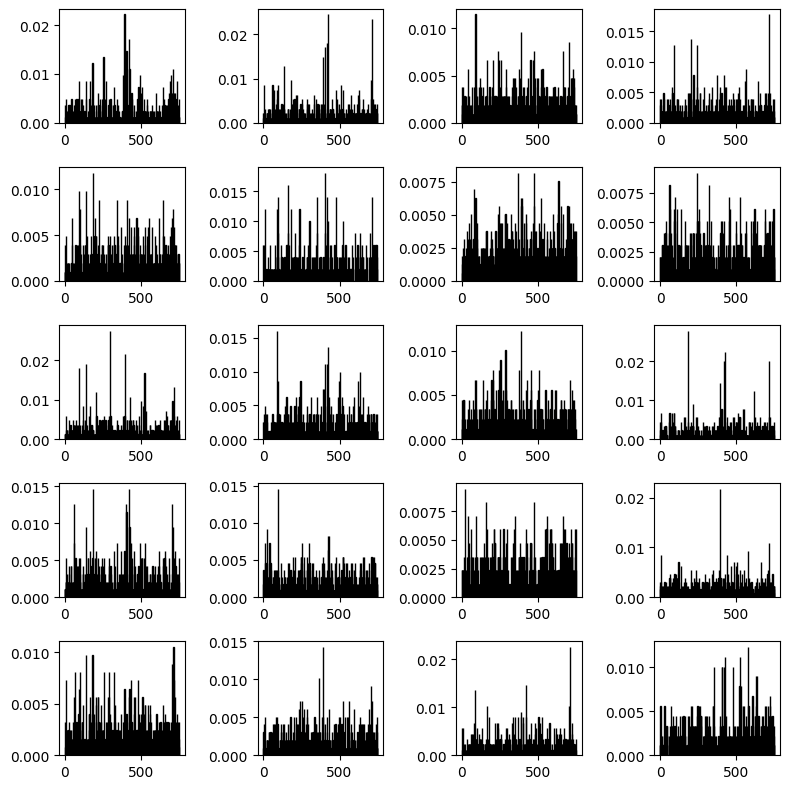

In [ ]:
visualize_histograms(histograms_list_training_norm)

### SVM

To classify the images, I utilize the **Support Vector
Machine (SVM)**, which is a supervised machine learning
algorithm used for classification and regression tasks. SVM
finds an optimal hyperplane to separate data points into
different classes by maximizing the margin between classes.

#### Train

I select the predictors and the feature target,for both training and test

In [ ]:
X_train=np.array(histograms_list_training_norm)
y_train=df_training['label']

In [ ]:
X_test=np.array(histograms_list_test_norm)
y_test=df_test['label']

To validate the model I use the Cross validation.
In particular I use **Stratify cross validation**.
With stratify cross validation we take the same percentage of sample, in each class , of the original training data.



In [ ]:
stratified_kfold = StratifiedKFold(n_splits=3,
                                       shuffle=True,
                                       random_state=250)

Now I set-up the pipeline

In [ ]:
pipeline = imbpipeline(steps = [
                                ['classifier',SVC(kernel=None,
                                                  gamma=None,
                                                  C=None,
                                                  probability=True)]])

I define the grid of parameters that will be used by the **grid search**, to perform hyperparameters tuning.

In [ ]:
# in param_grid are defined the hyperparameters
param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['linear','rbf']
              }

new_params = {'classifier__' + key: param_grid[key] for key in param_grid}

grid_search_SVM = GridSearchCV(estimator=pipeline,
                           param_grid=new_params,
                           scoring='accuracy',
                           cv=stratified_kfold,
                           verbose = 5,
                           n_jobs=-1) # it will use all the cpus available

Now I perform the grid search which find the best solution in the search space, where each element is a model fitted on some folds of data and with specific hyperparameters.

In [ ]:
# finding the best model
grid_search_SVM.fit(X_train, y_train.values.ravel())

best_estimator = grid_search_SVM.best_estimator_
cv_score = grid_search_SVM.best_score_
best_params = grid_search_SVM.best_params_

print(f'Best parameters: {best_params}')
print(f'Cross-validation score: {cv_score}')


Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best parameters: {'classifier__C': 100, 'classifier__gamma': 1, 'classifier__kernel': 'rbf'}
Cross-validation score: 0.004143356512832983


#### Test

I evalute the best model on test data, by computing some metrics:

- **Accuracy:** The ratio of correctly predicted instances to the total instances.

- **Precision:** The ratio of correctly predicted positive observations to the total predicted positives.

- **Recall:** The ratio of correctly predicted positive observations to all observations in the actual class.

- **F1 Score:** The weighted average of Precision and Recall.



In [ ]:
y_test_predict = grid_search_SVM.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy: 0.004382470119521913
precision: 0.005388618709180857
recall: 0.004382470119521913
f1: 0.001933612676425799


[]

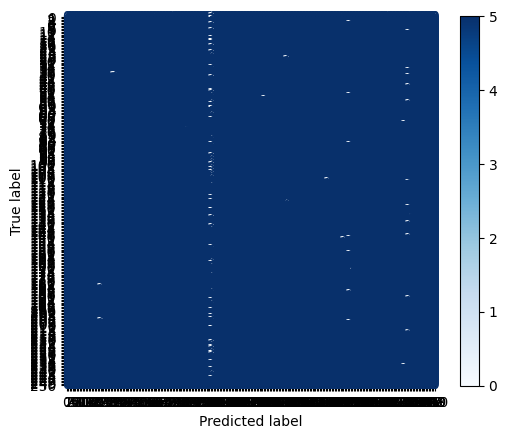

In [ ]:
accuracy = accuracy_score(y_test, y_test_predict)
precision = precision_score(y_test, y_test_predict, average='macro')
recall = recall_score(y_test, y_test_predict, average='macro')
f1 = f1_score(y_test, y_test_predict, average='macro')
ConfusionMatrixDisplay.from_predictions(y_test,
                                        y_test_predict,
                                        cmap=plt.cm.Blues)

print(f'accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1: {f1}')

plt.plot()

## Utility functions CNN

Some functions to load the metrics on wandb dashboard

In [ ]:
def log_image_table(images, predicted, labels, probs):
    #Create a wandb Table to log images, labels and predictions to
    table = wandb.Table(columns=["image", "pred", "target"]+[f"score_{i}" for i in range(251)])
    for img, pred, targ, prob in zip(images.to("cpu"), predicted.to("cpu"), labels.to("cpu"), probs.to("cpu")):
        table.add_data(wandb.Image(img[0].numpy()*255), pred, targ, *prob.numpy())
    wandb.log({"predictions_table":table}, commit=False)

In [ ]:
def train_log(loss, example_ct, epoch):
    loss = float(loss)

    # add metrics to wandb
    wandb.log({"epoch": epoch, "train/loss": loss}, step=example_ct)
    #print(f"Loss after " + str(example_ct).zfill(5) + f" examples: {loss:.3f}")

In [ ]:
def test_log(loss, accuracy, example_ct, epoch):
    loss = float(loss)
    accuracy = float(accuracy)

    # add metrics to wandb
    wandb.log({"epoch": epoch, "validation/loss": loss, "validation/accuracy": accuracy}, step=example_ct)
    #print(f"Loss/accuracy after " + str(example_ct).zfill(5) + f" examples: {loss:.3f}/{accuracy:.3f}")

Initializing the network parameters is critical.To avoid exploding gradient or vanishing gradient I apply **He initialization**;

The biases β  are set to zero and Ω are chosen from a normal distribution of wieghts with mean zero and variance 2/Dh where Dh is the number of hidden units in the previous layer.

In [ ]:
#INITIALIZATION FUNCTION
# He initialization of weights
def weights_init(layer_in):
    if isinstance(layer_in, nn.Conv2d):
        nn.init.kaiming_normal_(layer_in.weight, nonlinearity='relu')
        if layer_in.bias is not None:
            nn.init.constant_(layer_in.bias, 0)
    elif isinstance(layer_in, nn.Linear):
        nn.init.kaiming_normal_(layer_in.weight, nonlinearity='relu')
        if layer_in.bias is not None:
            nn.init.constant_(layer_in.bias, 0)


The steps for this phase will be the following ones:

1. Create the **class dataset**.
2. Design the **architecture of the network**
3. Train the network using **different hyperparameters**.
4. Select the **best-performing network** and train it for **additional epochs**.
5. **Evaluate** the networks performance.

## CNN classification

### Class Dataset

I define the Dataset class. This class is developed to manage the loading and preprocessing of images. The constructor of the class takes as inputs a CSV file containing the names and labels of the images and the path of the folder where the images are stored.

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self,data_csv, folder_path):
        self.data=pd.read_csv(data_csv)
        self.data=self.data.dropna()
        self.folder_path=folder_path

    def __len__(self):
        return len(self.data)

    def __getitem__(self,idx):
        img_name=self.data.loc[idx,'img_name']
        label=self.data.loc[idx,'label']
        img_path=os.path.join(self.folder_path,img_name)
        img = cv2.imread(img_path)


        img = cv2.resize(img,(256,256),interpolation=cv2.INTER_LINEAR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = np.transpose(img, (2, 0, 1))


        x = torch.tensor(img).float() / 255.0
        y = torch.tensor(label).long()

        return x,y

I check if the images are correctly processed.


In [ ]:
# get validation set
dataset = Dataset(train_csv,folder_img_training)
# get first item
x, y = dataset.__getitem__(12000)
# print shapes
print(x.size())
print(y.item())

torch.Size([3, 256, 256])
237


### Class Network

I define our custom CNN designed for image classification.

The architecture of this network combines various types of convolutional layers with residual connections, batch normalization, and adaptive pooling to enhance its learning capabilities and stability while managing the number of parameters.
At the end it's applied a fully connect layer to perform classification.

1. **Atrous Convolution(Convolution with dilation):** The network begins with an atrous convolution layer, which allows it to capture information from different parts of the image without losing resolution. This increases the receptive field and enables the network to learn more complex patterns.

2. **Inception blocks:**Following the initial convolution, the network employs Inception blocks. These blocks use multiple parallel paths with different filter sizes (1x1, 3x3, and 5x5 convolutions) and a pooling layer. The outputs from these parallel paths are then concatenated. This design allows the network to learn various filter sizes and capture diverse features from the input image.

3. **Residual block**:Residual blocks are used to address the shattered gradient problem and to train deeper networks. Each residual block includes:
  - Two convolutional layers
  - Batch normalization layers to stabilize and speed up training
  - A shortcut connection that adds the input of the block to its output.

4. **Adaptive Max pooling**: After the Inception and Residual blocks, AdaptiveMaxPool2d layers are used to reduce the spatial dimensions of the feature maps to a fixed size. This significantly reduces the number of parameters in the fully connected layers, making the network more efficient and less prone to overfitting.


After each convolutional layer in the residual blocks, **batch normalization** is applied. This is crucial for maintaining stable gradient flow and preventing the exploding gradient problem, especially when using residual connections.Also when we use residual network we should invert the order of the function, for this reason we apply activation to output

In [ ]:
class InceptionBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(InceptionBlock, self).__init__()

        if (out_channels % 4) == 0:
            n = out_channels // 4
            out_channels_branch1 = n
            out_channels_branch2 = n
            out_channels_branch3 = n
            out_channels_branch4 = n
        else:
            n = out_channels // 4
            r = out_channels%4
            out_channels_branch1 = n
            out_channels_branch2 = n + r
            out_channels_branch3 = n
            out_channels_branch4 = n

        # Branch 1x1
        self.branch1x1 = nn.Conv2d(in_channels, out_channels_branch1, kernel_size=1)

        # Branch 3x3
        self.branch3x3 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels_branch2, kernel_size=1),
            nn.Conv2d(out_channels_branch2, out_channels_branch2, kernel_size=3, padding=1)
        )

        # Branch 5x5
        self.branch5x5 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels_branch3, kernel_size=1),
            nn.Conv2d(out_channels_branch3, out_channels_branch3, kernel_size=5, padding=2)
        )

        # Branch di pooling
        self.branch_pool = nn.Sequential(
            nn.AvgPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, out_channels_branch4, kernel_size=1)
        )

    def forward(self, x):
        branch1x1 = self.branch1x1(x)
        branch3x3 = self.branch3x3(x)
        branch5x5 = self.branch5x5(x)
        branch_pool = self.branch_pool(x)

        # Concatena i rami lungo la dimensione dei canali
        outputs = [branch1x1, branch3x3, branch5x5, branch_pool]
        return torch.cat(outputs, 1)

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [ ]:
class ImageClassifier(nn.Module):
    def __init__(self,dropout):

        super(ImageClassifier, self).__init__()

        # Convolution with dilation
        self.conv1 = nn.Conv2d(3, 6, kernel_size=7, stride=2, padding=3, dilation=2)
        self.bn1 = nn.BatchNorm2d(6)

        # Residual blocks with Inception
        self.residual_block1 = ResidualBlock(6, 9)
        self.inception_block1 = InceptionBlock(9, 9)
        self.dynamic_pooling1 = nn.AdaptiveMaxPool2d((64, 64))

        self.residual_block2 = ResidualBlock(9, 12)
        self.inception_block2 = InceptionBlock(12, 12)
        self.dynamic_pooling2 = nn.AdaptiveMaxPool2d((32, 32))

        self.residual_block3 = ResidualBlock(12, 15)
        self.inception_block3 = InceptionBlock(15, 15)
        self.dynamic_pooling3 = nn.AdaptiveMaxPool2d((16, 16))

        self.drop= nn.Dropout(dropout)
        # Fully connected layers
        self.fc1 = nn.Linear(15 * 16 * 16, 251)
        #self.fc2 = nn.Linear(300, 251)

    def forward(self, x):
        # Convolution with dilation
        x = F.relu(self.bn1(self.conv1(x)))

        # Residual block 1
        x = self.residual_block1(x)
        x = self.inception_block1(x)
        x = self.dynamic_pooling1(x)

        # Residual block 2
        x = self.residual_block2(x)
        x = self.inception_block2(x)
        x = self.dynamic_pooling2(x)

        # Residual block 3
        x = self.residual_block3(x)
        x = self.inception_block3(x)
        x = self.dynamic_pooling3(x)

        # Flatten for fully connected layers
        x = x.view(x.size(0), -1)

        # Fully connected layers
        #x = F.relu(self.fc1(x))
        x=self.drop(x)
        x = self.fc1(x)

        return x


I check if the network has less than 1M parameters and if it works properly

In [ ]:
model= ImageClassifier(dropout=0.5)
# Count the number of parameters in the model
num_params = sum(p.numel() for p in model_.parameters() if p.requires_grad)

print(model)
print(f'Number of parameters in the model: {num_params}')

ImageClassifier(
  (conv1): Conv2d(3, 6, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), dilation=(2, 2))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (residual_block1): ResidualBlock(
    (conv1): Conv2d(6, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(9, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential(
      (0): Conv2d(6, 9, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (inception_block1): InceptionBlock(
    (branch1x1): Conv2d(9, 2, kernel_size=(1, 1), stride=(1, 1))
    (branch3x3): Sequential(
      (0): Conv2d(9, 3, kernel_size=(1, 1), stride=(1, 1))
      (1): Conv2d(3

In [ ]:
channels = 3
height = 256
width = 256

input_tensor , y = dataset.__getitem__(0)
input_tensor = input_tensor.unsqueeze(0)

print(input_tensor.shape)
# Pass the input tensor through the model
output = model(input_tensor)

# Print the output shape
print(f"Output shape: {output.shape}")


torch.Size([1, 3, 256, 256])
Output shape: torch.Size([1, 251])


### System definition

#### Configuration

In this section, we define the hyperparameters for the network. Specifically, we create a configuration that will be used by the **Weights and Biases agent** to set the different hyperparameters during various experiments. This allows us to systematically explore the effect of different hyperparameter settings on the model's performance.

Hyperparameters:
- **epochs** : The number of times the entire training dataset is passed through the network.
- **learning rate** : The step size at each iteration while moving towards a minimum of the loss function.
- **drop out** : The fraction of input units to drop during training. Dropout is a regularization technique that helps prevent overfitting by randomly setting a fraction of input units to zero at each update during training.
- **batch size** : The number of training examples utilized in one iteration
- **loss fuction** : The function that measures how well the model's predictions match the target values

Other hyperparameters like the optimizer or the scheduler of the learning rate will be specified directly in the training function.


In [ ]:
epochs=10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#optimizer= torch.optim.Adam(params=model.parameters(),lr=learning_rate)
#scheduler =torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.2)
loss_funct=nn.CrossEntropyLoss()

Also I specify the method that the wandb angent sweep will use to select the combination of hyperparameters; in this case they will be selected randomly.

In [ ]:
sweep_config = {
    'method': 'random'
    }

In [ ]:
parameters_dict = {
    'dropout': {
          'values': [0.3, 0.4, 0.5]
        },
    'batch_size':{
        'values':[30, 60, 90]
    },
    'epochs': {
        'value': epochs
        },
    'lr': {
        'values': [0.01, 0.001, 0.0001]
        }
}

sweep_config['parameters'] = parameters_dict

In [ ]:
import pprint
pprint.pprint(sweep_config)

{'method': 'random',
 'parameters': {'batch_size': {'values': [30, 60, 90]},
                'dropout': {'values': [0.3, 0.4, 0.5]},
                'epochs': {'value': 10},
                'lr': {'values': [0.01, 0.001, 0.0001]}}}


#### Dataset-Dataloader

I create the **training**, **test**, and v**alidation datasets** and **dataloaders** by instantiating the class created previously and initializing the dataloaders.

To create the validation set I take the **10% percentage** of the data from the training data.

The dataloader of the training data will be created directly on the training function.

In [ ]:
dataset=Dataset(train_csv,folder_img_training)


train_dataset = int(0.9 * len(dataset))  # 90% training
val_dataset = len(dataset) - train_dataset  # 10% validation
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_dataset,val_dataset])

val_dataloader=torch.utils.data.DataLoader(val_dataset, batch_size=1)

In [ ]:
test_dataset=Dataset(test_csv,folder_img_test)
test_dataloader=torch.utils.data.DataLoader(test_dataset, batch_size=1)

#### Validation

I create the function to validate the model on validation set.

In [ ]:
def validate_model(model, val_dataloader, loss_funct):
    model.eval()
    val_loss=0
    with torch.no_grad():
        correct=0
        for i, (x, y) in enumerate(val_dataloader):
            x=x.to(device)#image
            y=y.to(device)#label

            #Forward pass
            out=model(x)
            loss=loss_funct(out,y)
            val_loss+=loss.item()

            # Compute accuracy and accumulate
            _, predicted = torch.max(out.data, 1)
            correct += (predicted == y).sum().item()



        accuracy=correct / len(val_dataloader.dataset)
        val_loss=val_loss / len(val_dataloader.dataset)

    return val_loss, accuracy

#### Train

I create the function for the training of the model during the phase hyperparameters tuning.

In [ ]:
def train(config=None, val_dataloader=val_dataloader, train_dataset=train_dataset):
    with wandb.init(project="supervised", job_type="traninig", config=config) as run:
        # this config will be set by Sweep Controller
        config = wandb.config

        #Setting the network
        train_dataloader = train_dataloader=torch.utils.data.DataLoader(train_dataset, batch_size=config.batch_size)
        model = ImageClassifier(config.dropout).to(device)
        optimizer =  torch.optim.Adam(params=model.parameters(),lr=config.lr)
        scheduler =torch.optim.lr_scheduler.StepLR(optimizer, step_size=21, gamma=0.2)
        model.apply(weights_init)


        #Start the training
        best_val_loss=10000
        example_ct = 0
        for epoch in range(config.epochs):
            model.train()
            for batch_idx, (x, y) in enumerate(train_dataloader):

                x= x.to(device)
                y=y.to(device)
                optimizer.zero_grad()

                # forward pass
                out = model(x)
                train_loss = loss_funct(out, y)

                # backward pass
                train_loss.backward()
                optimizer.step()

                example_ct += len(x)


                print('Train Epoch: {} [{}/{} ({:.0%})]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(x), len(train_dataloader.dataset),
                    batch_idx / len(train_dataloader), train_loss.item()))

                train_log(train_loss, example_ct, epoch)

            # tell scheduler to consider updating learning rate
            scheduler.step()

            #Loss on training
            print('Epoch')
            print(f'train/train_loss: {train_loss}\n')

            val_loss, accuracy = validate_model(model, val_dataloader, loss_funct)

            # add validation loss and metrics to wandb
            test_log(val_loss, accuracy, example_ct, epoch)
            print(f"Train Loss: {train_loss:.3f}, Valid Loss: {val_loss:3f}, Accuracy: {accuracy:.2f}")


            #save best model
            curr_val_loss=val_loss
            if curr_val_loss < best_val_loss:
                best_val_loss=curr_val_loss

                model_artifact = wandb.Artifact(
                        "trained-model", type="model",
                        description="Trained NN model")

                torch.save(model.state_dict(), "trained_model.pth")
                model_artifact.add_file("trained_model.pth")
                wandb.save("trained_model.pth")

                run.log_artifact(model_artifact)


I create the function to train the best model

In [ ]:
def train_v2(model,train_dataloader, val_dataloader, epochs=50):
    with wandb.init(project="supervised", job_type="traninig") as run:
        model.to(device)

        model.train()
        optimizer =  torch.optim.Adam(params=model.parameters(),lr=0.001)
        scheduler =torch.optim.lr_scheduler.StepLR(optimizer, step_size=21, gamma=0.2)

        example_ct = 0
        for epoch in range(epochs):
            model.train()
            for batch_idx, (x, y) in enumerate(train_dataloader):

                x= x.to(device)
                y=y.to(device)
                optimizer.zero_grad()

                # forward pass
                out = model(x)
                train_loss = loss_funct(out, y)

                # backward pass
                train_loss.backward()
                optimizer.step()

                example_ct += len(x)


                print('Train Epoch: {} [{}/{} ({:.0%})]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(x), len(train_dataloader.dataset),
                    batch_idx / len(train_dataloader), train_loss.item()))

                train_log(train_loss, example_ct, epoch)

            # tell scheduler to consider updating learning rate
            scheduler.step()

            #Loss on training
            print('Epoch')
            print(f'train/train_loss: {train_loss}\n')

            val_loss, accuracy = validate_model(model, val_dataloader, loss_funct)

            # add validation loss and metrics to wandb
            test_log(val_loss, accuracy, example_ct, epoch)
            print(f"Train Loss: {train_loss:.3f}, Valid Loss: {val_loss:3f}, Accuracy: {accuracy:.2f}")


#### Test

I define the function for the test and evaluation of the model on test data.

In [ ]:
def test(model, test_dataloader, loss_funct, log_images=True, batch_idx=0):
  with wandb.init(project="supervised", job_type="test") as run:
      model.eval()
      test_loss=0
      accuracy=0
      correct=0
      example_ct=0
      predicted_list=[]
      with torch.no_grad():
          for i, (x, y) in enumerate(test_dataloader):
              x=x.to(device)#image
              y=y.to(device)#label

              #Forward pass
              out=model(x)
              loss=loss_funct(out,y)
              test_loss+=loss.item()

              # Compute accuracy and accumulate
              _, predicted = torch.max(out.data, 1)
              correct += (predicted == y).sum().item()
              predicted_list.append(predicted)

              # Log one batch of images to the dashboard, always same batch_idx.
              #if log_images and (i%200==0):
                  #log_image_table(x, predicted, y, out.softmax(dim=1))



          accuracy=correct / len(test_dataloader.dataset)
          test_loss=test_loss / len(test_dataloader.dataset)

          test_log(test_loss, accuracy, example_ct, epoch=0)

      return test_loss, accuracy,predicted_list

### Run training with agent

To run different experiments, with different hypeparameter I use an** agent (sweep)**, that **select randomly** the parameters.
I initialize sweep with the configuration created previously.

In [ ]:
wandb.login(key='insert your key')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
os.environ["WANDB_NOTEBOOK_NAME"] = "final_project_supervised.ipynb"


In [ ]:
sweep_id = wandb.sweep(sweep_config, project="supervised")

Create sweep with ID: th1ewiwh
Sweep URL: https://wandb.ai/cecca/supervised/sweeps/th1ewiwh


In [ ]:
wandb.agent(sweep_id, function=lambda: train(val_dataloader=val_dataloader,train_dataset=train_dataset), count=5)

wandb: Agent Starting Run: j886ue5e with config:
wandb: 	batch_size: 30
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	lr: 0.0001
wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find final_project_supervised.ipynb.
wandb: Currently logged in as: d-cecca (cecca). Use `wandb login --relogin` to force relogin
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Streaming output truncated to the last 5000 lines.
Train Epoch: 8 [63540/106627 (60%)]	Loss: 3.400566
Train Epoch: 8 [63570/106627 (60%)]	Loss: 3.264972
Train Epoch: 8 [63600/106627 (60%)]	Loss: 3.535677
Train Epoch: 8 [63630/106627 (60%)]	Loss: 3.762669
Train Epoch: 8 [63660/106627 (60%)]	Loss: 3.476377
Train Epoch: 8 [63690/106627 (60%)]	Loss: 3.685988
Train Epoch: 8 [63720/106627 (60%)]	Loss: 3.771908
Train Epoch: 8 [63750/106627 (60%)]	Loss: 3.330013
Train Epoch: 8 [63780/106627 (60%)]	Loss: 2.950509
Train Epoch: 8 [63810/106627 (60%)]	Loss: 3.602454
Train Epoch: 8 [63840/106627 (60%)]	Loss: 3.535262
Train Epoch: 8 [63870/106627 (60%)]	Loss: 3.662369
Train Epoch: 8 [63900/106627 (60%)]	Loss: 3.768764
Train Epoch: 8 [63930/106627 (60%)]	Loss: 3.655244
Train Epoch: 8 [63960/106627 (60%)]	Loss: 3.096366
Train Epoch: 8 [63990/106627 (60%)]	Loss: 3.743592
Train Epoch: 8 [64020/106627 (60%)]	Loss: 3.304954
Train Epoch: 8 [64050/106627 (60%)]	Loss: 3.694843
Train Epoch: 8 [64080/106627 (6

wandb: Agent Starting Run: lgczq50h with config:
wandb: 	batch_size: 60
wandb: 	dropout: 0.5
wandb: 	epochs: 10
wandb: 	lr: 0.01
wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find final_project_supervised.ipynb.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Streaming output truncated to the last 5000 lines.
Train Epoch: 7 [20760/106627 (19%)]	Loss: 4.179969
Train Epoch: 7 [20820/106627 (20%)]	Loss: 4.264976
Train Epoch: 7 [20880/106627 (20%)]	Loss: 3.885868
Train Epoch: 7 [20940/106627 (20%)]	Loss: 3.923992
Train Epoch: 7 [21000/106627 (20%)]	Loss: 4.017823
Train Epoch: 7 [21060/106627 (20%)]	Loss: 3.581700
Train Epoch: 7 [21120/106627 (20%)]	Loss: 4.272817
Train Epoch: 7 [21180/106627 (20%)]	Loss: 4.382578
Train Epoch: 7 [21240/106627 (20%)]	Loss: 3.658344
Train Epoch: 7 [21300/106627 (20%)]	Loss: 3.644984
Train Epoch: 7 [21360/106627 (20%)]	Loss: 4.226619
Train Epoch: 7 [21420/106627 (20%)]	Loss: 3.977437
Train Epoch: 7 [21480/106627 (20%)]	Loss: 3.643136
Train Epoch: 7 [21540/106627 (20%)]	Loss: 3.696084
Train Epoch: 7 [21600/106627 (20%)]	Loss: 3.934335
Train Epoch: 7 [21660/106627 (20%)]	Loss: 3.855405
Train Epoch: 7 [21720/106627 (20%)]	Loss: 3.797857
Train Epoch: 7 [21780/106627 (20%)]	Loss: 4.158201
Train Epoch: 7 [21840/106627 (2

wandb: Agent Starting Run: f09bgezi with config:
wandb: 	batch_size: 30
wandb: 	dropout: 0.4
wandb: 	epochs: 10
wandb: 	lr: 0.0001
wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find final_project_supervised.ipynb.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Streaming output truncated to the last 5000 lines.
Train Epoch: 8 [63540/106627 (60%)]	Loss: 3.451539
Train Epoch: 8 [63570/106627 (60%)]	Loss: 3.455482
Train Epoch: 8 [63600/106627 (60%)]	Loss: 3.509112
Train Epoch: 8 [63630/106627 (60%)]	Loss: 4.033960
Train Epoch: 8 [63660/106627 (60%)]	Loss: 3.484524
Train Epoch: 8 [63690/106627 (60%)]	Loss: 3.979375
Train Epoch: 8 [63720/106627 (60%)]	Loss: 3.982974
Train Epoch: 8 [63750/106627 (60%)]	Loss: 4.215901
Train Epoch: 8 [63780/106627 (60%)]	Loss: 3.610824
Train Epoch: 8 [63810/106627 (60%)]	Loss: 4.166151
Train Epoch: 8 [63840/106627 (60%)]	Loss: 4.183807
Train Epoch: 8 [63870/106627 (60%)]	Loss: 3.651121
Train Epoch: 8 [63900/106627 (60%)]	Loss: 4.097226
Train Epoch: 8 [63930/106627 (60%)]	Loss: 3.386678
Train Epoch: 8 [63960/106627 (60%)]	Loss: 3.562387
Train Epoch: 8 [63990/106627 (60%)]	Loss: 3.781006
Train Epoch: 8 [64020/106627 (60%)]	Loss: 4.333672
Train Epoch: 8 [64050/106627 (60%)]	Loss: 4.143194
Train Epoch: 8 [64080/106627 (6

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wt6l9ug3 with config:
wandb: 	batch_size: 30
wandb: 	dropout: 0.5
wandb: 	epochs: 10
wandb: 	lr: 0.001
wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find final_project_supervised.ipynb.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Streaming output truncated to the last 5000 lines.
Train Epoch: 8 [63540/106627 (60%)]	Loss: 3.071721
Train Epoch: 8 [63570/106627 (60%)]	Loss: 3.737289
Train Epoch: 8 [63600/106627 (60%)]	Loss: 3.297645
Train Epoch: 8 [63630/106627 (60%)]	Loss: 3.975694
Train Epoch: 8 [63660/106627 (60%)]	Loss: 4.295665
Train Epoch: 8 [63690/106627 (60%)]	Loss: 3.872303
Train Epoch: 8 [63720/106627 (60%)]	Loss: 3.851549
Train Epoch: 8 [63750/106627 (60%)]	Loss: 3.599837
Train Epoch: 8 [63780/106627 (60%)]	Loss: 3.168694
Train Epoch: 8 [63810/106627 (60%)]	Loss: 3.655247
Train Epoch: 8 [63840/106627 (60%)]	Loss: 3.944234
Train Epoch: 8 [63870/106627 (60%)]	Loss: 3.740494
Train Epoch: 8 [63900/106627 (60%)]	Loss: 3.999324
Train Epoch: 8 [63930/106627 (60%)]	Loss: 3.399272
Train Epoch: 8 [63960/106627 (60%)]	Loss: 3.435060
Train Epoch: 8 [63990/106627 (60%)]	Loss: 3.146737
Train Epoch: 8 [64020/106627 (60%)]	Loss: 3.934790
Train Epoch: 8 [64050/106627 (60%)]	Loss: 3.190708
Train Epoch: 8 [64080/106627 (6

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ytjwr1g1 with config:
wandb: 	batch_size: 60
wandb: 	dropout: 0.4
wandb: 	epochs: 10
wandb: 	lr: 0.001
wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find final_project_supervised.ipynb.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Streaming output truncated to the last 5000 lines.
Train Epoch: 7 [20760/106627 (19%)]	Loss: 3.437531
Train Epoch: 7 [20820/106627 (20%)]	Loss: 3.217757
Train Epoch: 7 [20880/106627 (20%)]	Loss: 3.828733
Train Epoch: 7 [20940/106627 (20%)]	Loss: 3.493293
Train Epoch: 7 [21000/106627 (20%)]	Loss: 3.182552
Train Epoch: 7 [21060/106627 (20%)]	Loss: 3.251364
Train Epoch: 7 [21120/106627 (20%)]	Loss: 3.138905
Train Epoch: 7 [21180/106627 (20%)]	Loss: 3.442186
Train Epoch: 7 [21240/106627 (20%)]	Loss: 3.051599
Train Epoch: 7 [21300/106627 (20%)]	Loss: 3.292815
Train Epoch: 7 [21360/106627 (20%)]	Loss: 3.145447
Train Epoch: 7 [21420/106627 (20%)]	Loss: 3.377660
Train Epoch: 7 [21480/106627 (20%)]	Loss: 3.274908
Train Epoch: 7 [21540/106627 (20%)]	Loss: 3.762191
Train Epoch: 7 [21600/106627 (20%)]	Loss: 3.192986
Train Epoch: 7 [21660/106627 (20%)]	Loss: 3.703560
Train Epoch: 7 [21720/106627 (20%)]	Loss: 2.876017
Train Epoch: 7 [21780/106627 (20%)]	Loss: 3.498559
Train Epoch: 7 [21840/106627 (2

### Run train on the best network

In [ ]:
# Initialize WandB
run = wandb.init()
artifact = run.use_artifact('cecca/supervised/trained-model:v25', type='model')
artifact_dir = artifact.download()

# Assuming your artifact contains a model file named 'model.pth'
model_path = os.path.join(artifact_dir, 'trained_model.pth')

wandb: Currently logged in as: d-cecca (cecca). Use `wandb login --relogin` to force relogin


wandb:   1 of 1 files downloaded.  


In [ ]:
# Now you can load the model using PyTorch
model = ImageClassifier(0.5)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [ ]:
train_dataloader =torch.utils.data.DataLoader(train_dataset, batch_size=30)


In [ ]:
train_v2(model,train_dataloader,val_dataloader,epochs=40)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Streaming output truncated to the last 5000 lines.
Train Epoch: 38 [77250/106627 (72%)]	Loss: 2.866785
Train Epoch: 38 [77280/106627 (72%)]	Loss: 2.622574
Train Epoch: 38 [77310/106627 (72%)]	Loss: 1.837002
Train Epoch: 38 [77340/106627 (73%)]	Loss: 2.316006
Train Epoch: 38 [77370/106627 (73%)]	Loss: 2.919924
Train Epoch: 38 [77400/106627 (73%)]	Loss: 2.472024
Train Epoch: 38 [77430/106627 (73%)]	Loss: 3.030607
Train Epoch: 38 [77460/106627 (73%)]	Loss: 2.388500
Train Epoch: 38 [77490/106627 (73%)]	Loss: 2.748781
Train Epoch: 38 [77520/106627 (73%)]	Loss: 2.252594
Train Epoch: 38 [77550/106627 (73%)]	Loss: 3.070212
Train Epoch: 38 [77580/106627 (73%)]	Loss: 2.647547
Train Epoch: 38 [77610/106627 (73%)]	Loss: 2.985608
Train Epoch: 38 [77640/106627 (73%)]	Loss: 2.758343
Train Epoch: 38 [77670/106627 (73%)]	Loss: 2.524055
Train Epoch: 38 [77700/106627 (73%)]	Loss: 3.175995
Train Epoch: 38 [77730/106627 (73%)]	Loss: 2.455241
Train Epoch: 38 [77760/106627 (73%)]	Loss: 2.987775
Train Epoch: 

### Run test

I do the inference on the test data

In [ ]:
test_loss, accuracy,predicted_list=test(model, test_dataloader, loss_funct, batch_idx=0)


In [ ]:
y_test=test_dataloader.dataset.data['label'].ravel()

In [ ]:
predicted_list=[i.cpu().item() for i in predicted_list]

I evaluate the result by using the same metrics of the first part.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy: 0.09471402367850593
precision: 0.08625984804788783
recall: 0.08982471382961092
f1: 0.0842085213394547


[]

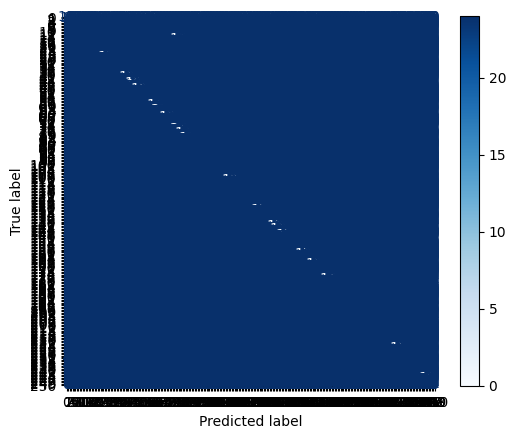

In [ ]:
accuracy = accuracy_score(y_test, predicted_list)
precision = precision_score(y_test, predicted_list, average='macro')
recall = recall_score(y_test, predicted_list, average='macro')
f1 = f1_score(y_test, predicted_list, average='macro')
ConfusionMatrixDisplay.from_predictions(y_test,
                                        predicted_list,
                                        cmap=plt.cm.Blues)

print(f'accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1: {f1}')

plt.plot()